# Tutorial: Attention is all you need

In this tutorial we will implement [Vaswani et al.](https://arxiv.org/abs/1706.03762)'s transductive model that is entirely based on attention mechanism instead of previously used recurrence models like RNNs. 
For example, in the case of English to German translation, an RNN would need to be trained sequentially such that the hidden state at time `t-1` along with the input at time `t` need to be known to compute the German translation upto that point. 
This not only introduces difficulty in training variable sized sequences but also draws upon an assumption that the translation changes from one part of the sequence to the other. 

Transformer architecture proposed by [Vaswani et al.](https://arxiv.org/abs/1706.03762) overcomes these problems by making the model entirely based on self-attention mechanism, thereby allowing for faster training due to efficient batching as well as doing away with the assumption on sequential nature of translation task. 
We will build such a transformer from scratch and train it on [Multimodal Machine Translation](http://www.statmt.org/wmt16/multimodal-task.html#task1) task in this tutorial. 
This task is of appropriate size for us to get a full sense of how Transformer works. 
It has 29,000 English to German translations text for training, 1,014 for validation and 1,000 samples for test dataset. 


The final evaluation will be done using METEOR metric which computes weighted harmonic mean of precision and recall (recall is given a weight of 90%) of the candidate translation with respect to the reference translation. 
Read more about this metric [here](https://en.wikipedia.org/wiki/METEOR).


Some usefule resources to understand Transformers (also helped in building this tutorial):
1. [Attention Is All You Need [Original paper] ](https://arxiv.org/abs/1706.03762)
2. [Transformers from Scratch](http://peterbloem.nl/blog/transformers)
3. [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
4. [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
5. [How to code the transformer in PyTorch](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec)

[[Vaswani et al. 2017] Attention Is All You Need](https://arxiv.org/abs/1706.03762)

## Setup

We will need the following libraries 

- [`torch`](https://pytorch.org/)
- [`torchtext`](https://github.com/pytorch/text)
- [`spacy`](https://spacy.io/usage) 
- [`nltk`](https://www.nltk.org/index.html) 

Follow the link to the libraries above to see the instructions to install the libraries. We will be using `spacy`'s specialized tokenizer (see below), so run the following commands to install the necessary modules. 

```python
pip install -U spacy
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```

We will use `nltk`'s [`nltk.translate.meteor_score`](https://www.nltk.org/_modules/nltk/translate/meteor_score.html) to evaluate the performance of our translator. 
This library requires `wordnet` corpus which can be installed using [`nltk.download()`](https://www.nltk.org/data.html). 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence 

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k

import nltk
import math
import numpy as np
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt 
import pathlib

# fix seed for reproducibility 
rng = np.random.RandomState(1)
torch.manual_seed(rng.randint(np.iinfo(int).max))

# it is a good practice to define `device` globally
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)

Using GPU: cuda


## Machine Translation task


In this tutorial, we will focus on building a model that translates English sentences to German.
To access such dataset , we will use `torchtext.datasets.Multi30k` that provies us these sentence pairs.
The function also separates out `train`, `valid`, and `test` datasets for us. 

In [2]:
LANGUAGE_PAIRS = ['de', 'en']
Multi30k(root="./data", split=("train", "valid", "test"), language_pair=LANGUAGE_PAIRS)

(<torchtext.data.datasets_utils._RawTextIterableDataset at 0x7fd4284acd00>,
 <torchtext.data.datasets_utils._RawTextIterableDataset at 0x7fd4284b4040>)

### Load training data

We will load English-German pairs of sentences in the form of an iterator. 
Since the iterators need to be loaded again once they reach the end we will write a function `get_data_iter` to do this. 
We will call this function whenever we need to refresh the data iterator. 

In [3]:
def get_data_iter(itertype):
    return Multi30k(root="./data", split=itertype, language_pair=LANGUAGE_PAIRS)

In [4]:
train_iter = get_data_iter("train")

# example call
print("An example of English-German pair of sentences\n")
de, en= next(train_iter)
print(en, de)

An example of English-German pair of sentences

Two young, White males are outside near many bushes.
 Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.



### Preprocess text data

Text data, in its raw form, can't be digested directly by the machine learning models.
Therefore, we need to transform this data before machine learning models can learn any patterns in it. 
We will be using the following transformations (in order):

- **tokenization**: It refers to breaking a sentence into the list of unique words and punctuations. We will use `spacy`'s specialized tokenizer for this purpose. 


- **token to index**: The tokenized words in a sentence need to be transformed to their unique indices. To do this, we will need to iterate through the entire tokenized corpus to build a mapping from tokens to index. With the help of this mapping, we can convert any list of token into its corresponding unique indices. We will need to specify the index with which we will denote special cases (e.g., unknown words) so that the vocabulary builder does not use those numbers to denote any tokens. 
    - *Unknown words*: Words can be classified as unknown either (a) when only the words above certain frequency in the corpus are recognized by the vocabulary builder or (b) when a word is not present in the training corpus. Therefore, we need to reserve a number or index to denote unknown words
    
    - *beginning-of-sentence (BOS)*: this index will denote the beginning of a sentence
    
    - *end-of-sentence (EOS)*: this index will denote the end of a sentence
    
    - *padding index*: While training, different sentences need to be batched together. Therefore, we need to define a padding index to mark the irrelevant part of the input tensors. 
    

- **marking beginning and end of a sentence**: The beginning and ending of a sentence might be clear in the input, but the model need to predict the end-of-sentence token in its output. Therefore, we will pad the indexed tokens with BOS and EOS indices. 

In [5]:
SRC_LANGUAGE = LANGUAGE_PAIRS[0]
TGT_LANGUAGE = LANGUAGE_PAIRS[1]

SPACY_LANGUAGE_MAP = {
    'en': 'en_core_web_sm',
    'de': 'de_core_news_sm'
}

## tokenization
token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language=SPACY_LANGUAGE_MAP[SRC_LANGUAGE])
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language=SPACY_LANGUAGE_MAP[TGT_LANGUAGE])

## token to index

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


def yield_tokens(data_iter, language):
    idx = LANGUAGE_PAIRS.index(language)
    
    for sentence in data_iter:
        yield token_transform[language](sentence[idx])

vocab_transform = {}
vocab_transform[SRC_LANGUAGE] = build_vocab_from_iterator(yield_tokens(get_data_iter("train"), SRC_LANGUAGE), min_freq=1, specials=special_symbols, special_first=True)
vocab_transform[TGT_LANGUAGE] = build_vocab_from_iterator(yield_tokens(get_data_iter("train"), TGT_LANGUAGE), min_freq=1, specials=special_symbols, special_first=True)

for v in vocab_transform.values():
    v.set_default_index(UNK_IDX)

## marking beginning and end of a sentence
def bos_eos_pad(tokens):
    return torch.cat((
            torch.tensor([BOS_IDX]), 
            torch.tensor(tokens), 
            torch.tensor([EOS_IDX])
    ))

## Putting it all together
def get_text_transform(language):
    def func(sentence):
        x = token_transform[language](sentence)
        x = vocab_transform[language](x)
        x = bos_eos_pad(x)
        return x
    return func

text_transform = {}
text_transform[SRC_LANGUAGE] = get_text_transform(SRC_LANGUAGE)
text_transform[TGT_LANGUAGE] = get_text_transform(TGT_LANGUAGE)

# n tokens
SRC_N_TOKENS = len(vocab_transform[SRC_LANGUAGE])
TGT_N_TOKENS = len(vocab_transform[TGT_LANGUAGE])

In [6]:
# example call
print("An example of English-German pair of sentences\n", "-"*50)
train_iter = get_data_iter('train')
de, en = next(train_iter)
print(en, de)
print("\n After token transformation\n", "-"*50)
en = token_transform['en'](en)
de = token_transform['de'](de)
print(en,"\n", de)

print("\n After token to index transformation\n", "-"*50)
en = vocab_transform['en'](en)
de = vocab_transform['de'](de)
print(en, "\n", de)

print("\n After marking beginning and end of a sentence \n","-"*50)
en = bos_eos_pad(en)
de = bos_eos_pad(de)
print(en, "\n", de)


An example of English-German pair of sentences
 --------------------------------------------------
Two young, White males are outside near many bushes.
 Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.


 After token transformation
 --------------------------------------------------
['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '\n'] 
 ['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.', '\n']

 After token to index transformation
 --------------------------------------------------
[20, 26, 16, 1170, 809, 18, 58, 85, 337, 1340, 6, 5] 
 [22, 86, 258, 32, 88, 23, 95, 8, 17, 113, 7911, 3210, 5, 4]

 After marking beginning and end of a sentence 
 --------------------------------------------------
tensor([   2,   20,   26,   16, 1170,  809,   18,   58,   85,  337, 1340,    6,
           5,    3]) 
 tensor([   2,   22,   86,  258,   32,   88,   23,   95,    8,   17,  113, 7911,


### Batching input

As mentioned above, we will pad the sentences with `PAD_IDX` while batching several `text_transform`ed sentences together. 
In Pytorch, several cpu workers load observations (sentence pairs in our case) from the dataset. 
These observations are handed over [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html) which uses `collate_fn` to batch these observations together. 
In our case, we will overwrite the default `collate_fn` to transform and pad the input sentences with `PAD_IDX`. 

In [7]:
# from https://pytorch.org/tutorials/beginner/translation_transformer.html#collation

# function to collate data samples into batch tesors
def collate_fn(batch):
    """
    Args:
        batch (iterator): each element is a source sentence and target sentence 
    
    Returns:
        src_batch (torch.tensor): [n_sentences x max_sentence_lenght]
        tgt_batch (torch.tensor): [n_sentences x max_sentence_lenght]
    """
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.permute(1,0), tgt_batch.permute(1,0)

In [8]:
train_iter = get_data_iter('train')
batch = [next(train_iter) for _ in range(10)]
src, tgt = collate_fn(batch)

print("input shape:", src.shape)
print("output shape:", tgt.shape)
print("Note: each row is a single sentence. It begins with BOS_IDX and ends with an EOS_IDX. Each of them are padded with PAD_IDX towards the end.")
print("-"*50)
print("source:")
print(src)
print('target:')
print(tgt)
print("-"*50)
print("Max length in the source batch:", src.shape[1])
print("Max length in the target batch:", tgt.shape[1])

input shape: torch.Size([10, 18])
output shape: torch.Size([10, 17])
Note: each row is a single sentence. It begins with BOS_IDX and ends with an EOS_IDX. Each of them are padded with PAD_IDX towards the end.
--------------------------------------------------
source:
tensor([[    2,    22,    86,   258,    32,    88,    23,    95,     8,    17,
           113,  7911,  3210,     5,     3,     1,     1,     1],
        [    2,    85,    32,    11,   848,  2209,    16,  8269,     5,     3,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    2,     6,    70,    28,   220,     8,    16,  6770,    56,   509,
             5,     3,     1,     1,     1,     1,     1,     1],
        [    2,     6,    13,     8,     7,    48,    42,    31,    12,    14,
           544,    10,   699,    16,   249,     5,     3,     1],
        [    2,    22,    32,    54,    57,  1351,    10,   410,   175,    30,
             5,     3,     1,     1,     1,     1,     1,     1],
       

In [9]:
def get_sample_batch(type, n):
    data_iter = get_data_iter(type)
    batch = [next(data_iter) for _ in range(n)]
    src, tgt = collate_fn(batch)
    return src, tgt


### Masking Input

A mask is needed to prevent the attention mechanism attending to unwanted parts of the input.
We will come to specifics of masking for our later in this tutorial. 
Denoting the query matrix by `Q`, the key matrix by `K`, the attention matrix is given by $A' = softmax(\frac{1}{\sqrt{d}}QK^T)$.
Given a mask $Mask$ of the same shape as the attention matrix $A'$ containing `-inf` at positions where the query should not attend to the key, the modified attention looks like $A'' = softmax(\frac{1}{\sqrt{d}}QK^T + Mask) $.
Alternatively, one can use a boolean matrix as a mask and multiply $A'$ by it to achieve the same effect. 
Another alterative is to use mask  along with [`masked_fill`](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html) on $A'$.
We will use `masked_fill`, so our masks will need to carry $0$ wherever we want attention scores to be zero. 

## Transformer Model

Finally, we will focus on building the model itself.
As a refresher, the Transformer consists of an  Encoder and a Decoder arranged as shown in the figure below 

<img src="img/transformer_architecture.jpeg" width=500>

Following modules will be required as we build a Transformer:
- Attention 
- Multi-Head Attention (MHA)
- Encoder layer (includes MHA, Feed-forward network and normalization layers)
- Decoder layer (includes MHA and normalization layers)
- Positional Encoder
- Embedding 
- Transformer (includes all of the above)

### Attention Mechanism

In [10]:
def attention(Q, K, V, mask=None, dropout=None):
    """
    Implements attention mechanism.
    
    Args:
        Q (torch.tensor): [batch_size x heads x max_sentence_length x dimension] Query matrix 
        K (torch.tensor): [batch_size x heads x max_sentence_length x dimension] Key matrix 
        V (torch.tensor): [batch_size x heads x max_sentence_length x dimension] Value matrix 
        mask (torch.tensor): [max_sentence_length x max_sentence_length] mask to prevent certain queries attending to certain keys
        dropout (F.dropout): 
    
    Returns:
        (torch.tensor): Convex combination of V where weights are decided by the attention mechanism
    """
    d_k = K.shape[-1]
    # bs x n_heads x max_sentence_length x max_sentence_length
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, V)
    return output


In [11]:
# example call
Q = torch.randn((2, 5, 6)) #  batches,  max lenght, dimensions
K = torch.randn((2, 5, 6)) 
V = torch.randn((2, 5, 6)) 
mask = torch.triu(torch.ones((5, 5)))
A = attention(Q, K, V, mask)
print(A)

tensor([[[-0.2917,  0.2030, -0.0241, -0.1567, -0.8315,  0.3906],
         [-0.2814,  0.0168,  0.0443, -0.2762, -0.6763,  0.4037],
         [-0.4314, -0.4576,  0.1414, -0.4957, -0.1379,  0.4085],
         [-0.4715, -1.0414, -0.3449, -0.6028, -0.5030, -0.5483],
         [-1.1019, -0.1122, -1.8294, -0.2636,  0.0742,  0.6129]],

        [[ 0.0711, -0.1645,  0.1569,  0.1725, -0.2601, -0.8144],
         [-0.4003, -0.1361, -0.0959,  0.3303, -0.1820, -1.1710],
         [-0.8718,  0.0593, -0.1327,  0.0225, -0.0523, -1.1015],
         [-1.4276, -0.2562,  0.8617, -1.4720,  0.0981, -0.7935],
         [-2.7512, -1.4687, -0.8328, -1.1847,  1.3479, -0.7077]]])


### Multi-head attention

We need to break down the computation of attention scores across several heads.
Intuitively, each head captures a different context or meaning with which predcitions can be made. 

**NOTE**: There are no non-linearities in this entire module. There are only learnable parameters associated with affine transformations.

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1): 
        
        super().__init__()
        
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_head = d_model // n_heads
        
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        
        batch_size = q.shape[0]
        
        # break the output such that the last two dimensions are heads x d_head
        Q = self.Q(q).view(batch_size, -1, self.n_heads, self.d_head)
        K = self.K(k).view(batch_size, -1, self.n_heads, self.d_head)
        V = self.V(v).view(batch_size, -1, self.n_heads, self.d_head)
        
        # take transpose so that last two dimensions are max_sentence_length x d_head (as required for the attention module)
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # batch_size x n_heads x max_sentence_length x d_head
        attn = attention(Q, K, V, mask, self.dropout)
        
        # transpose back to get batch_size x sentence_length x d_model
        # use contiguous to reset the ordering of elements (i.e. stride and offset): https://stackoverflow.com/a/52229694/3413239
        concat = attn.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return concat

In [13]:
# example call

mha = MultiHeadAttention(2, 6)

Q = torch.randn((2, 5, 6)) #  batches,  max lenght, dimensions
K = torch.randn((2, 5, 6)) 
V = torch.randn((2, 5, 6)) 
mask = torch.triu(torch.ones((5, 5)))
A = mha(Q, K, V, mask)
print(A)

tensor([[[ 0.1447, -0.6918,  0.1898,  0.6029, -0.0876,  0.3331],
         [ 0.0449, -0.7385,  0.3187,  0.9161, -0.0386,  0.4605],
         [ 0.1109, -0.6332,  0.0467,  0.3191,  0.0298, -0.0258],
         [ 0.2577, -0.6966,  0.0944,  0.8975,  0.2523,  0.5626],
         [ 0.4721, -1.1727,  0.8475,  1.3529,  0.1810,  0.9411]],

        [[-0.2844, -0.8080,  0.0522,  0.2147, -0.2880,  0.5618],
         [-0.2871, -0.9818,  0.3108,  0.3006, -0.3267,  0.5448],
         [-0.4639, -0.7047,  0.2446,  1.2110, -0.0913,  0.9853],
         [-0.4774, -0.7622,  0.4695,  0.8070, -0.4765,  0.4962],
         [ 0.2008, -0.6720,  0.1382, -0.1983, -0.5061,  0.2870]]],
       grad_fn=<ViewBackward>)


### Encoder Layer

Now, we will write the code for a single Encoder layer.

<img src="img/encoder_layer.png" width=200>

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=1024, dropout=0.1):
        
        super().__init__()
        
        # mha
        self.mha = MultiHeadAttention(n_heads, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        
        # feed forward
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        
        # dropout regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        z = self.mha(x, x, x, mask) # mha
        z = self.dropout(z) # refer to the section 5.4 of Vaswani et al. 
        x = self.norm1(x + z) # add & norm
        
        z = self.ff(x) # feed forward
        z = self.dropout(z) # refer to the section 5.4 of Vaswani et al. 
        x = self.norm2(x + z) # add & norm
        return x

In [15]:
# example call 
d = 6
enc = EncoderLayer(d, 2, 12)
x = torch.randn((2, 5, d)) #  batches,  max length, dimension
mask = torch.triu(torch.ones((5, 5)))
enc(x, mask)

tensor([[[-0.7906,  0.6911,  1.0619, -1.7183,  0.8935, -0.1376],
         [ 1.6604, -0.0494,  0.5481, -1.5806,  0.0811, -0.6596],
         [-0.6099,  0.2894,  0.8634, -1.0677,  1.5892, -1.0645],
         [-1.1059,  0.1271, -0.7195, -0.3437,  2.0310,  0.0110],
         [ 1.3387, -1.8766,  0.1767, -0.3966,  0.0547,  0.7031]],

        [[-1.4936,  1.0349,  0.6758, -1.2234,  0.1579,  0.8484],
         [ 0.3962, -0.0779,  0.1800, -1.9930,  1.3454,  0.1494],
         [-0.8095, -0.1038,  1.8352, -1.1576,  0.6647, -0.4290],
         [-1.9694,  0.4286,  0.3364,  0.2887, -0.3552,  1.2708],
         [ 1.6060, -0.2246, -0.0480,  0.9108, -1.0209, -1.2232]]],
       grad_fn=<NativeLayerNormBackward>)

### Decoder Layer

Now we will write the code for the decoder layer.

<img src="img/decoder_layer.png" width=200>

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=1024, dropout=0.1):
        
        super().__init__()
        
        # masked-mha
        self.mha1 = MultiHeadAttention(n_heads, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        
        # mha
        self.mha2 = MultiHeadAttention(n_heads, d_model)
        self.norm2 = nn.LayerNorm(d_model)
                
        # feed-forward
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)
        
        # dropout regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, e_x, src_mask, tgt_mask):
        z = self.mha1(x, x, x, tgt_mask) # masked mha 
        z = self.dropout(z) # refer to the section 5.4 of Vaswani et al. 
        x = self.norm1(x + z) # add & norm 
        
        z = self.mha2(x, e_x, e_x, src_mask) # mha 
        z = self.dropout(z) # refer to the section 5.4 of Vaswani et al. 
        x = self.norm2(x + z) # add & norm 
        
        z = self.ff(x)
        z = self.dropout(z) # refer to the section 5.4 of Vaswani et al. 
        x = self.norm3(x + z)
        
        return x  

In [17]:
# example call 
d = 6
dec = DecoderLayer(d, 2, 12)
x = torch.randn((2, 5, d)) #  batches,  max length, dimension
e_x =  torch.randn((2, 5, d))
mask = torch.triu(torch.ones((5, 5)))
dec(x, e_x, mask, mask)

tensor([[[-0.7562,  2.0306, -0.8037, -0.7246,  0.3523, -0.0984],
         [-1.2380, -0.6624,  1.7459, -0.3651,  0.8566, -0.3369],
         [-0.4523,  0.5500,  0.8861, -0.9722,  1.3657, -1.3774],
         [ 1.5138,  0.4752, -1.0475, -1.1798,  0.8138, -0.5755],
         [-0.6800,  0.8640, -1.8419,  0.7752,  0.8931, -0.0103]],

        [[-0.7590,  0.5925, -1.2833, -0.5151,  0.1982,  1.7667],
         [ 0.8687,  0.4475, -0.8547, -1.8353,  0.6491,  0.7247],
         [ 0.8336, -0.4662,  0.1935, -1.8508,  1.2746,  0.0154],
         [-0.3029, -0.2974,  0.0867, -1.7515,  0.8335,  1.4316],
         [ 1.0650,  1.0816, -1.6475, -0.8527,  0.4866, -0.1330]]],
       grad_fn=<NativeLayerNormBackward>)

### Input Embedding

Now we will write a class that can handle learnable word embeedings for us. 
This class will hold word vectors of appropriate dimensions, where values in each dimensions are learned via backpropagation. 
Checkout [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) to do this.

<img src="img/embedding.png" width=500>


In [18]:
class TokenEmbedding(nn.Module):
    def __init__(self, n_tokens, emb_size):
        super().__init__()
        
        self.embedding = nn.Embedding(n_tokens, emb_size)
        self.emb_size = emb_size 
    
    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

The reasons for multiplying embeddings with `math.sqrt(self.emb_size)` are hypothesized here: https://datascience.stackexchange.com/a/87909/1165

A plausible explanation seems like - 

*It is to make the positional encoding relatively smaller. This means the original meaning in the embedding vector won’t be lost when we add them together* because positional encoding can't have values greater than 1 (see below). 

### Positional Encoding

Poitional Encodings are used to inject dependence on word ordering. This is done via adding a position dependent vector. Such a vector is constructed as follows - 

A word at $pos$ position has $i^{th}$ dimension encoded as following

$$
\begin{equation*}
PE(pos, i) = \begin{cases}
\sin\Big(\frac{pos}{10000^{\frac{i}{d_{model}}}}\Big), &\text{if i is even} \\ \\
\cos\Big(\frac{pos}{10000^{\frac{i-1}{d_{model}}}}\Big), &\text{if i is odd} \\
\end{cases}
\end{equation*}
$$

Note that the exponent of $10000$ will be same for consecutive even and odd numbers.


<img src="img/pe.png" width=500>

In [19]:
def get_position_encodings(max_len, d):
    """
    Creates encoding
    
    Args:
        max_len (int): number of positions to encode
        d (int): dimension of encoding
    
    Returns:
        (torch.tensor): [max_len, d] each row is the encoding for that row position
    """
    exp_coeff = torch.arange(0, d, 2) / d
    arg = torch.exp(-exp_coeff * math.log(10000)) # take exp of log for numerical stability
    
    pos = torch.arange(0, max_len).reshape(max_len, 1)
    pos_embedding = torch.zeros((max_len, d))
    pos_embedding[:, 0::2] = torch.sin(pos * arg)
    pos_embedding[:, 1::2] = torch.cos(pos * arg)
    return pos_embedding

number of unique rows in encoding: 100
number of positions: 100


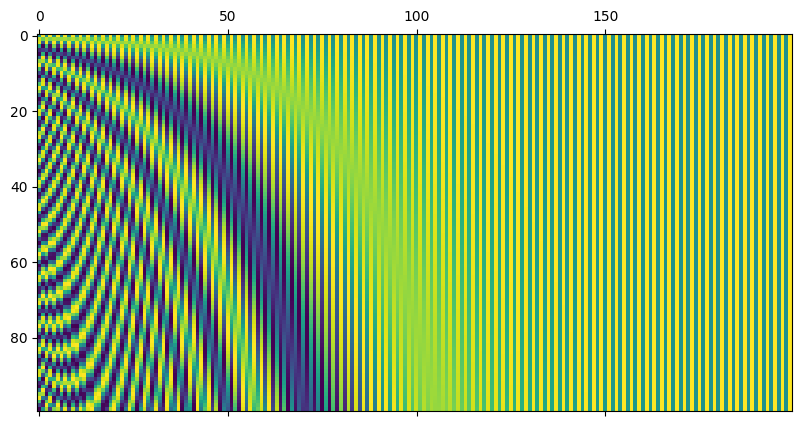

In [20]:
enc_size = 200
n_pos = 100
pos_enc = get_position_encodings(n_pos, enc_size)

# check whether all rows are unique `torch.unique`
print(f"number of unique rows in encoding: {pos_enc.unique(dim=0).shape[0]}")
print(f"number of positions: {n_pos}")


# how does the encoding looks like?
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=100)
ax.matshow(pos_enc)


### Masking for Machine Translation Task (as required by Transformer)

To simplify our discussion here, we will consider attention scores for a single sentence and one head. 
Let's denote the attention scores by $A$ (dimension: `query_length x key_length`) such that $A_{qk}$ denotes how much weight does the $q^{th}$ query gives to the $k^{th}$ key.
When query, keys, and values are computed from the same input, it is termed as self-attention.
Masking lets us nullify the weights of certain queries on certain keys. 

There are three MHA units in Transformer and the corresponding masks required by them are as follows:


**(A) Source padding mask**:

The MHA unit in the Encoder uses self-attention on source sentence, therefore, `query_length` and `key_length` are the same as number of positions in the source sentence. 
For this MHA unit, $A_{qk}$ denotes the weight of the $q^{th}$-token in the sentence on the $k^{th}$-token in the same sentence. 
Naturally, we don't want any $q^{th}$-token to attend to irrelevant padding-tokens, i.e., $\forall k \text{  s.t.  } src[k] == PAD\text{_}IDX$.
Thus, such a mask should contain 0 wherever either of the query or key token is a padding token.


**(B) Target-to-Source padding mask**:

The MHA unit that connects encoder to decoders act upon target sentence's embeddings as queries and encoded embeddings as keys and values. 
The idea is to let the (partially) translated embedding (query) attend to the embeddings of all the tokens (keys and values) in the source sentence.
Therefore, $A_{qk}$ denotes the weight of $q^{th}$-query in the translated sentence on the $k^{th}$-key in the source sentence. 
Once again, we want to prevent queries from attending to keys that correspond to the padding tokens in the source sentence.
Thus, such a mask should contain 0 wherever there is a padding token in the source sentence. 
This will look exactly as the mask explained in (A) above. 

**(C) Target no-peak mask**: 

Machine translation task is mathematically modeled as Conditional Language Models (CLM). We are interested in modeling the likelihood of an output sequence $\{y_i\}_{i=1}^{t}$ conditioned on an input $x$, i.e, $P(y_1, y_2, ..., y_t | x)$. This is in contrast to language models (LM) where we are interested in modeling the unconditional probability $p(y_1, y_2, ..., y_t) = \Pi_{t=1}^{n}p(y_t | y_{<t})$ of a sequence $\{y_i\}_{i=1}^{t}$. CLMs are modeled similarly as $P(y_1, y_2, ..., y_t | x) = \Pi_{t=1}^{n}p(y_t | y_{<t}, x)$. Therefore, we need to predict one token at a time, $y_t$, conditioned on the past outputs $\{y_{<t}\}$ and the source $x$. 


[*Teacher forcing*](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/): Transformer naturally uses teacher forcing mechanism, wherein the ground truth for $\{y_{<t}\}$ are used as an input, and the task is to predict $y_t$ conditioned on $\{y_{<t}\}$  and $x$.

The output of the Masked-MHA unit in the decoder is such that, for each sentence, the embeddings at the $q^{th}$ index is the weighted (by attention scores) sum of values (target embeddings). 
For example, the Masked-MHA's embedding at $q=0$  will represent value-embedding corresponding to the `<BOS>` token in the target `TokenEmbeddings`. 
Note that the $q=0$ embedding will be same for all the sentences. 
With the help of next MHA unit that connects encoder and the decoder, the output embeddings corresponding to $q=0$ will be used to predict the next token in the target language. 

Similarly, the Masked-MHA's embedding at $q=1$  will represent weighted sum of value-embeddings corresponding to the target `TokenEmbeddings` of `<BOS>` token and the ground-truth 1st token.
The subsequent MHA unit will output embeddings for $q=1$ that can be used to predict the next token (i.e, 2nd token) in the target language. 

Thus, Masked-MHA's mask will be such that $Mask_{qk} = 0 \ \ \forall \ \ k \text{  s.t.  } k > q$.


In [21]:
src, tgt = get_sample_batch('train', 10)

src_padding_mask =  (src != PAD_IDX).unsqueeze(1).unsqueeze(2)
print(src_padding_mask.shape)

N, L = tgt.shape
tgt_mask = torch.tril(torch.ones((L, L)), diagonal=0).expand(N, 1, L, L)
print(tgt_mask.shape)

torch.Size([10, 1, 1, 18])
torch.Size([10, 1, 17, 17])


In [22]:
def create_masks(src, tgt):
    src_padding_mask =  (src != PAD_IDX).unsqueeze(1).unsqueeze(2)
    
    N, L = tgt.shape
    tgt_mask = torch.tril(torch.ones((L, L)), diagonal=0).expand(N, 1, L, L)
    
    return src_padding_mask, tgt_mask


### Transformer

Putting it all together ... 



In [23]:
d_model = 6

src_embedding = TokenEmbedding(SRC_N_TOKENS, d_model)
tgt_embedding = TokenEmbedding(TGT_N_TOKENS, d_model)
pos_encoding = get_position_encodings(20, d_model)


src, tgt = get_sample_batch('train', 10)
src_padding_mask, tgt_mask = create_masks(src, tgt)

print("Source sentences shape: ", src.shape)
print("Target sentences shape: ", tgt.shape)
print("Source embedding shape: ", src_embedding(src).shape)
print("source padding mask shape:", src_padding_mask.shape)
print("target mask shape:", tgt_mask.shape)

x = src_embedding(src) + pos_encoding[:src.shape[1], :].unsqueeze(0)
print("Source embeddings' shape after adding positional encodings:", x.shape)

Source sentences shape:  torch.Size([10, 18])
Target sentences shape:  torch.Size([10, 17])
Source embedding shape:  torch.Size([10, 18, 6])
source padding mask shape: torch.Size([10, 1, 1, 18])
target mask shape: torch.Size([10, 1, 17, 17])
Source embeddings' shape after adding positional encodings: torch.Size([10, 18, 6])


In [24]:
x = src_embedding(src) + pos_encoding[:src.shape[1], :].unsqueeze(0)
z = tgt_embedding(tgt) + pos_encoding[:tgt.shape[1], :].unsqueeze(0)

n_heads = 2
encoders = [
        EncoderLayer(d_model, n_heads), 
        EncoderLayer(d_model, n_heads)
]

x = encoders[0](x, src_padding_mask)
x = encoders[1](x, src_padding_mask)

decoders = [
    DecoderLayer(d_model, n_heads),
    DecoderLayer(d_model, n_heads)
]

z = decoders[0](z, x, src_padding_mask, tgt_mask)
z = decoders[1](z, x, src_padding_mask, tgt_mask)

print("pre-softmax outputs' shape: ", z.shape)

pre-softmax outputs' shape:  torch.Size([10, 17, 6])


In [25]:
class Transformer(nn.Module):
    """
    Args:
       src_n_tokens (int): vocabulary size or number of unique tokens in the source language
       tgt_n_tokens (int): vocabulary size or number of unique tokens in the target language
       n_encoders (int): number of encoders to stack on top of each other
       n_decoders (int): number of decoders to stack on top of each other
       d_model (int): embedding dimension size
       n_heads (int): number of heads in multi-head attention
       d_ff (int): hidden dimension of feed forward networks
       dropout (float): dropout probability
       max_length (int): maximum length for positional encodings (optional).
    """
    def __init__(self, src_n_tokens, tgt_n_tokens, n_encoders, n_decoders,  d_model, n_heads, d_ff=1024, dropout=0.1, max_length=1000):
        super().__init__()
        
        self.input_args = [src_n_tokens, tgt_n_tokens, n_encoders, n_decoders,  d_model, n_heads, d_ff, dropout, max_length]
        
        # embedddings + positional encoding
        self.src_embeddings = TokenEmbedding(src_n_tokens, d_model)
        self.tgt_embeddings = TokenEmbedding(tgt_n_tokens, d_model)
        self.register_buffer('positional_encodings', nn.Parameter(get_position_encodings(max_length, d_model)))
        
        # encoders
        self.encoders = nn.ModuleList([
                EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_encoders) 
        ])
        
        # decoders
        self.decoders = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_decoders) 
        ])
        
        # final linear (pre-softmax)
        self.out = nn.Sequential(
            nn.Linear(d_model, tgt_n_tokens),
        )
        
        # dropout regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_padding_mask, tgt_mask):
        # encode
        e_x = self.encode(src, src_padding_mask)
        
        # decode 
        z = self.decode(tgt, e_x, src_padding_mask, tgt_mask)
        
        # linear (pre-softmax)
        out = self.out(z)
        
        return out

    def encode(self, src, src_padding_mask):
        """
        Returns the encodings for src sentence
        """
        # encoder inputs
        src_emb = self.src_embeddings(src) + self.positional_encodings[:src.shape[1], :].unsqueeze(0) 
        src_emb = self.dropout(src_emb) # dropout described in section 5.4 of Vaswani et al.
        
        # encoder
        for encoder in self.encoders:
            e_x = encoder(src_emb, src_padding_mask)
        
        return e_x
    
    def decode(self, tgt, e_x, src_padding_mask, tgt_mask):
        """
        Returns the pre-softmax decoder outputs
        """
        # decoder inputs 
        tgt_emb = self.tgt_embeddings(tgt) + self.positional_encodings[:tgt.shape[1], :].unsqueeze(0) 
        tgt_emb = self.dropout(tgt_emb) # dropout described in section 5.4 of Vaswani et al.
        
        # decoder 
        z = tgt_emb
        for decoder in self.decoders:
            z = decoder(z, e_x, src_padding_mask, tgt_mask)
        
        return z


In [26]:
# example call
model = Transformer(SRC_N_TOKENS, TGT_N_TOKENS, 2, 2, 6, 2)

src, tgt = get_sample_batch('train', 10)
src_padding_mask, tgt_mask = create_masks(src, tgt)

out = model(src, tgt, src_padding_mask, tgt_mask)
print("shape of output: ", out.shape)
print("number of tokens in the target language:", TGT_N_TOKENS)

shape of output:  torch.Size([10, 17, 10838])
number of tokens in the target language: 10838


### Number of parameters

Let's look at the number of learnable parameters in the Transformer with the configurations same as in  [Vaswani et al.](https://arxiv.org/abs/1706.03762).

In [27]:
def mem_size(model):
    """
    Get model size in GB (as str: "N GB")
    """
    mem_params = sum(
        [param.nelement() * param.element_size() for param in model.parameters()]
    )
    mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs
    return f"{mem / 1e9:.4f} GB"

def num_params(model):
    """
    Print number of parameters in model's named children
    and total
    """
    s = "Number of parameters:\n"
    n_params = 0
    for name, child in model.named_children():
        n = sum(p.numel() for p in child.parameters())
        s += f"  • {name:<15}: {n}\n"
        n_params += n
    s += f"{'total':<19}: {n_params}"

    return s

def pp_model_summary(model):
    print(num_params(model))
    print(f"{'Total memory':<18} : {mem_size(model)}")

In [28]:
N_ENCODERS = 6
N_DECODERS = 6
EMB_SIZE = 512
N_HEADS = 8
FFN_HID_DIM = 512

model = Transformer(SRC_N_TOKENS, TGT_N_TOKENS, N_ENCODERS, N_DECODERS, EMB_SIZE, N_HEADS, FFN_HID_DIM)
pp_model_summary(model)

Number of parameters:
  • src_embeddings : 9838080
  • tgt_embeddings : 5549056
  • encoders       : 7891968
  • decoders       : 12625920
  • out            : 5559894
  • dropout        : 0
total              : 41464918
Total memory       : 0.1679 GB


## Training the transformer

### Scaling down the transformer 

The original configuration is meant to be for a bigger dataset (refer section 5.1 and 5.2 of [Vaswani et al.](https://arxiv.org/abs/1706.03762)). 
Since we are dealing with a toy problem we will scale the transformer down by reducing the number of encoders and embedding dimensions.


In [29]:
N_ENCODERS = 3
N_DECODERS = 3
EMB_SIZE = 128
N_HEADS = 8
FFN_HID_DIM = 256

model = Transformer(SRC_N_TOKENS, TGT_N_TOKENS, N_ENCODERS, N_DECODERS, EMB_SIZE, N_HEADS, FFN_HID_DIM)
pp_model_summary(model)

Number of parameters:
  • src_embeddings : 2459520
  • tgt_embeddings : 1387264
  • encoders       : 347904
  • decoders       : 497280
  • out            : 1398102
  • dropout        : 0
total              : 6090070
Total memory       : 0.0249 GB


### Loss function

The authors use Label Smoothing with $\epsilon_{ls} = 0.1$, which makes the prediction targets less peaky as compared to one-hot targets. 
Thus, instead of measuring our loss against one-hot targets, we will be measuring it against a smoothed distribution where the value at the target class will be  confidence,$C = 1 - \epsilon_{ls}$ and smotthing, $S = \frac{\epsilon_{ls}}{n_{classes} - 1}$ otherwise.

Refer to [Muller et al. to](https://arxiv.org/abs/1906.02629) understand - Why does Label Smoothing help?


Assuming that the model outputs softmax outputs for a single sentence as $\hat{y}$ and the prediction is the $t^{th}$ class such that $y_t = 1$ and 0 otherwise.

$$
\begin{equation*}
\begin{split}
\mathcal{L}_{ls}(\hat{y}, y) &= CE(\ C \times y + S \times (1-y)\ |\ \hat{y}\ ) \\
& = CE(\ (C - S) y + S \ \mathbf{1} \ |\   \hat{y}\ ) \\
& = CE(\ (C - S) y \ | \ \hat{y}\ ) + CE(\ S \ \mathbf{1} \ | \ \hat{y}) \\
& = -(C - S) \times \log{\hat{y}_t} - S \times \sum_{i} \log{\hat{y}_i} \\ 
\end{split}
\end{equation*}
$$


Here $CE(p, q) = -\sum_{x}p(x)\log{q(x)}$ is the standard cross-entropy loss.

As $\log{\hat{y}_i}$ is a log of softmax operation, and [`nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) is a numerically stable operation to compute log-softmax, we will use that instead.
To do this, we will make the model output pre-softmax logits only. 

Such a modified loss function can be implemented as an `nn.Module` with the output of its `forward` function as a scalar value. 
Refer to [this stackoverflow post](https://stackoverflow.com/a/66773267/3413239) on various ways to implement this loss function.

[[Muller et al. 2019] Why does Label Smoothing help?](https://arxiv.org/abs/1906.02629)


In [30]:
# adapted from https://stackoverflow.com/a/66773267/3413239

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, epsilon=0.0):
        super().__init__()
        self.smoothing = epsilon / (classes - 2) # classes to not consider for smoothing:  PAD_IDX class, target class
        self.confidence = 1 - epsilon 
    
    def forward(self, x, target):
        
        # mask out PAD_IDX
        tgt_padding_mask = (target != PAD_IDX).unsqueeze(2)
        tgt_padding_mask = tgt_padding_mask.to(x.device)
        x = x.masked_fill(tgt_padding_mask==0, 0)
    
        # compute CE loss on smoothed distribution
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        target_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(2)).squeeze(2)
        smooth_loss = -logprobs.sum(dim=-1)
        loss = (self.confidence - self.smoothing) * target_loss + self.smoothing * smooth_loss
        return loss.mean()

In [31]:
# example call
loss = LabelSmoothingLoss(TGT_N_TOKENS, 0.1)

model = Transformer(SRC_N_TOKENS, TGT_N_TOKENS, 2, 2, 6, 2)

src, tgt = get_sample_batch('train', 10)
src_padding_mask, tgt_mask = create_masks(src, tgt)
out = model(src, tgt, src_padding_mask, tgt_mask)

print("shape of output: ", out.shape)
print("number of tokens in the target language:", TGT_N_TOKENS)
print("tgt shape: ", tgt.shape)

loss(out, tgt)

shape of output:  torch.Size([10, 17, 10838])
number of tokens in the target language: 10838
tgt shape:  torch.Size([10, 17])


tensor(9.3256, grad_fn=<MeanBackward0>)

### Iterate over a dataloader

We will write a function that iterates over a batch of inputs and computes an appropriate loss over that dataset. 
This will help us save from writing redundant code for validation and test datasets. 


In [32]:
def process(model, data_loader, loss_fn, optimizer=None):
    
    running_loss, n_samples = 0, 0
    
    for src, tgt in data_loader:
        
        n_samples += src.shape[0] # number of sentences 
        
        # 
        src = src.to(device)
        tgt = tgt.to(device)

        # ignore last token in the tgt because at the time of predicting the last token, available inputs will be everything before that token
        tgt_input = tgt[:, :-1]

        # create masks
        src_padding_mask, tgt_mask = create_masks(src, tgt_input)
        src_padding_mask = src_padding_mask.to(device)
        tgt_mask = tgt_mask.to(device)
        
        # forward pass
        logits = model(src, tgt_input, src_padding_mask, tgt_mask)
        
        # target predictions are made for 1st token onwards. 0th token is assumed to be <BOS> by design of the model. Read no-peak masking (above) for more details.
        tgt_out = tgt[:, 1:]
    
        # compute loss
        loss = loss_fn(logits, tgt_out)
        
        # backward pass 
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / n_samples


### Define Optimizer
Section 5.3 of [Vaswani et al.](https://arxiv.org/abs/1706.03762) discusses the the learning rate (LR) scheduling for Adam optimizer. 
We will implement such a LR scheduler now. 

For clarity, the suggested learning rate at step $t$ is given by,

$$lr(t) = \sqrt{d_{model}} \times min(\frac{1}{\sqrt{t}}, \ \ t \times \frac{1}{WS^{1.5}}), $$

where $WS$ is the number of warm up steps before which the learning rate increases linearly. 
Thereafter, it decreases proportionally to the "inverse square root of the the step number".


Following code is motivated from [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html).

In [33]:
class WarmupOpt:
    def __init__(self, optimizer, d_model, warmup_steps):
        
        self.optimizer = optimizer
        self.d_model = d_model
        self.ws = warmup_steps
        
        self.t = 0
        self._rate = 0
        
    def step(self):
        """
        the call to optimizer.step comes here first
        """
        self.t += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step=None):
        if step is None:
            step = self.t

        return self.d_model**(-0.5) * min(step**(-0.5), step * self.ws**(-1.5))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

        

# refer to section 5.3 of Vaswani et al. 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
optimizer = WarmupOpt(optimizer, d_model=EMB_SIZE, warmup_steps=4000)
        

### Train

Finally, lets write the whole training loop

In [34]:
def train(model, loss_fn):
    model.to(device)
    
    # fix seed for reproducibility 
    rng = np.random.RandomState(1)
    torch.manual_seed(rng.randint(np.iinfo(int).max))

    # create a model directory to store the best model
    model_dir = pathlib.Path("./models").resolve()
    if not model_dir.exists():
        model_dir.mkdir()

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
    optimizer = WarmupOpt(optimizer, d_model=EMB_SIZE, warmup_steps=4000)

    # validation dataloader 
    val_dataloader = torch.utils.data.DataLoader(list(get_data_iter('valid')), batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    
    # logging
    best_val_loss = np.inf
    train_losses, val_losses = [], []
    no_improvement_cnt = 0
    
    for epoch in range(NUM_EPOCHS):
        print(f"@ epoch {epoch}", end="")

        # training loss
        train_dataloader = torch.utils.data.DataLoader(get_data_iter('train'), batch_size=BATCH_SIZE, collate_fn=collate_fn)
        train_loss = process(model, train_dataloader, loss_fn, optimizer)

        # validation loss
        with torch.no_grad():
            val_loss = process(model, val_dataloader, loss_fn)

        # save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_dir / "best.ckpt")
            no_improvement_cnt = 0
        else:

            # if there has been no improvement in validation loss, stop early
            no_improvement_cnt += 1

            if no_improvement_cnt % 10 == 0:
                print("\nEarly stopping!")
                break

        # logging
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"\ttrain_loss: {train_loss: .5f}, val_loss: {val_loss:.5f}")

    print(f"best val loss: {best_val_loss:.5f}")

    # load the best model
    model = model.__class__(*model.input_args)
    model.load_state_dict(torch.load(model_dir / "best.ckpt"))
    model = model.to(device) 
    
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
    }
    return model, metrics  


In [35]:
NUM_EPOCHS = 50
BATCH_SIZE = 128 

N_ENCODERS = 3
N_DECODERS = 3
EMB_SIZE = 128
N_HEADS = 8
FFN_HID_DIM = 256
model = Transformer(SRC_N_TOKENS, TGT_N_TOKENS, N_ENCODERS, N_DECODERS, EMB_SIZE, N_HEADS, FFN_HID_DIM)
pp_model_summary(model)

# initialization as in https://pytorch.org/tutorials/beginner/translation_transformer.html
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

        
# loss function 
loss_fn = LabelSmoothingLoss(classes=TGT_N_TOKENS, epsilon=0.1) # refer to section 5.4 of Vaswani et al.

model, metrics = train(model, loss_fn)

Number of parameters:
  • src_embeddings : 2459520
  • tgt_embeddings : 1387264
  • encoders       : 347904
  • decoders       : 497280
  • out            : 1398102
  • dropout        : 0
total              : 6090070
Total memory       : 0.0249 GB
@ epoch 0	train_loss:  0.07079, val_loss: 0.06792
@ epoch 1	train_loss:  0.06312, val_loss: 0.06071
@ epoch 2	train_loss:  0.05793, val_loss: 0.05686
@ epoch 3	train_loss:  0.05514, val_loss: 0.05498
@ epoch 4	train_loss:  0.05341, val_loss: 0.05355
@ epoch 5	train_loss:  0.05198, val_loss: 0.05236
@ epoch 6	train_loss:  0.05077, val_loss: 0.05151
@ epoch 7	train_loss:  0.04979, val_loss: 0.05092
@ epoch 8	train_loss:  0.04899, val_loss: 0.05044
@ epoch 9	train_loss:  0.04832, val_loss: 0.05019
@ epoch 10	train_loss:  0.04777, val_loss: 0.05009
@ epoch 11	train_loss:  0.04727, val_loss: 0.04994
@ epoch 12	train_loss:  0.04688, val_loss: 0.04975
@ epoch 13	train_loss:  0.04658, val_loss: 0.04971
@ epoch 14	train_loss:  0.04627, val_loss: 0.049

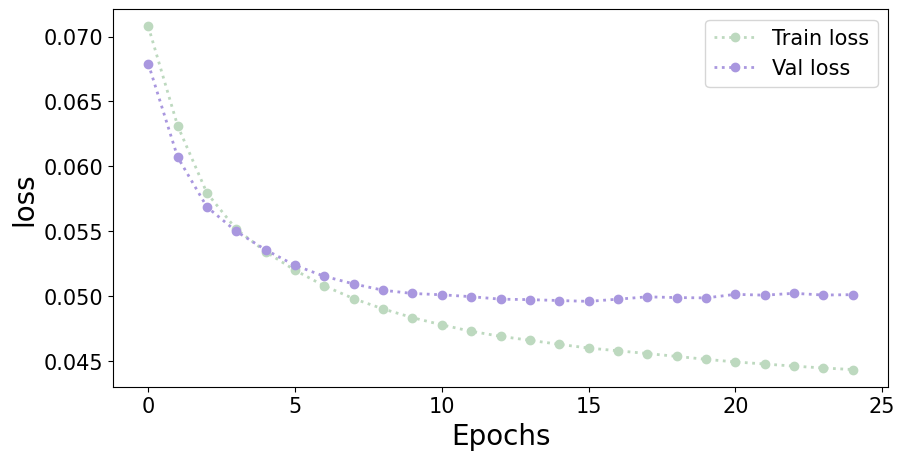

In [36]:
# plot losses
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

axs.plot(metrics['train_losses'], color="#BDD9BF", marker="o", label="Train loss", linestyle=":", linewidth=2)
axs.plot(metrics['val_losses'], color="#A997DF", marker="o", label="Val loss", linestyle=":", linewidth=2)
axs.set_ylabel("loss", fontsize=20)

axs.set_xlabel("Epochs", fontsize=20)

# tick size
for tick in axs.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)

for tick in axs.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# legend
axs.legend(prop={"size":15})


## Inference

Now that we have a trained model, we need to use it to perform translation. 
For this, we will need to go back to the definition of CLMs, which models the likelihood of observing a sequence of words, i.e. $P(y_1, y_2, ..., y_t \ |\ x) = \prod\limits_{i=1}^{t} p(y_{i} \ | \ y_{<i}, x)$.
Thus, the inference procedure aims at finding the sequence $\{\hat{y}_i\}_{i=1}^t$ with the maximum likelihood conditioned on $x$, i.e., $\hat{y} =\underset{y_1, y_2, ..., y_t}{\operatorname{arg max}}P(y_1, y_2, ..., y_t \ |\ x) = \underset{y_1, y_2, ..., y_t}{\operatorname{arg max}}\ \prod\limits_{i=1}^{t} p(y_{i} \ | \ y_{<i}, x)$.

Since we formulated the problem as sequence prediction, i.e., our model yields $p(y_{i} \ | \ y_{<i}, x)$, we will make this inference sequentially.
Hence, finding the best sequence $\{y_i\}_{i=1}^{t}$ is NP-Hard as one will have to check all the possibilities before finding the sequence with the maximum likelihood.
Note that for a sequence of length $L$ if there are $N$ possible values, there will be a total of $N^{L}$ possibile sequences.
For example, if there are $N=10^5$ unique tokens and a sequence is of length $L=5$, there will be $10^{25}$ possible sequences. 
As a result we will have to fall back on approximation algorithms to find a maximum likelihood sequence. 

One can view the above search problem as drawing inference on a tree of depth $L$ with the root node as `<BOS>` token. 
Each node will have $N$ children, i.e., $N$ possible next token. 

<img src="img/tree.png" width=1000>

Finding the most likely sequence then boils down to moving from a node to another.
Some of the ways to about it are:
- **Greedy Decoding**: Move to the most likely node given the current node in the tree. This results in the sequence $\prod\limits_{i=1}^{t}\underset{y_i}{\operatorname{arg max}}p(y_i \ | \ y_{<i}, x)$. Note it is **not equivalent to finidng the maximum likleihood sequence** because $\underset{y_1, y_2, ..., y_t}{\operatorname{arg max}}\ \prod\limits_{i=1}^{t} p(y_{i} \ | \ y_{<i}, x) \neq \prod\limits_{i=1}^{t}\underset{y_i}{\operatorname{arg max}}p(y_i \ | \ y_{<i}, x)$

- **Beam Search (k)**: At each iteration, **extend only the top $k$ likely sequences by $k$ most likely extensions** to each of them. $k$ is also termed at beam size. At each step, we will have $k^2$ sequences and we will keep only the top-$k$ sequences. 

In [37]:
def greedy_decoding(model, src, max_len):
    """
    Implements greedy search for a most likely translation of `src`.
    
    Args:
        model (Transformer): model to extract p(y_t | y_{<t}, x)
        src (torch.tensor): [n_sentences x max_sentence_length] source sentence with paddings, BOS and EOS tokens (as expected by the model)
        max_len (int): maximum length of the translated sentence.
    
    Returns:
        (torch.tensor): indices of tokens in a target sentence
    """
    model.to(device)
    model.eval() # no use of dropout from here on
    
    src = src.to(device)
    N  = src.shape[0]  # n_sentences
    eos_tracker = set()
    with torch.no_grad():
        
        # src padding
        src_padding_mask = (src != PAD_IDX).unsqueeze(1).unsqueeze(2)
        src_padding_mask = src_padding_mask.to(device)
        
        # source encoding (x)
        e_x = model.encode(src, src_padding_mask) # source encodings
        
        # output decoding (y_i)
        outputs = torch.empty((N, max_len + 1), dtype = torch.long)
        outputs[:] = PAD_IDX
        outputs = outputs.to(device)
        outputs[:, 0] = BOS_IDX
        
        for i in range(1, max_len+1):
            tgt_mask = torch.tril(torch.ones(N, 1, i, i), diagonal=0)
            tgt_mask = tgt_mask.to(device)
            
            out = model.out(model.decode(outputs[:, :i], e_x, src_padding_mask, tgt_mask))
            ix = out[:, -1, :].data.topk(1).indices # last position's predictions only
            
            rem_sentences = [i not in eos_tracker for i in range(N)]
            outputs[rem_sentences, i] = ix[rem_sentences, 0]
            
            eos_tracker.update(set(torch.where(ix[:, 0] == EOS_IDX)[0].tolist())) # these sentences have finished
            
            if len(eos_tracker) == N:
                break
    
    return outputs.to('cpu')

In [38]:
# token to text conversion

def get_readable_tokens(tokens, language):
    assert len(tokens.shape) == 1, f"unrecognized input shape: {tokens.shape}"
    return vocab_transform[language].lookup_tokens(tokens.numpy())
    
def get_readable_text(readable_tokens):
    return " ".join(readable_tokens).replace("<bos>", "").replace("<eos>", "").replace("<pad>", "")

In [41]:
# check the predictions
src, tgt = get_sample_batch('valid', 10)
pred_sentences = greedy_decoding(model, src, 40)

for i in range(src.shape[0]):
    s = get_readable_tokens(src[i, :], SRC_LANGUAGE)
    y = get_readable_tokens(tgt[i, :], TGT_LANGUAGE)
    y_hat = get_readable_tokens(pred_sentences[i, :], TGT_LANGUAGE)
    meteor = nltk.translate.meteor_score.meteor_score([get_readable_text(y)], get_readable_text(y_hat))
    print(get_readable_text(s))
    print(get_readable_text(y))
    print(get_readable_text(y_hat))
    print("METEOR:", meteor)
    print("-"*50)

 Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen                    
 A group of men are loading cotton onto a truck                
 A group of men are loading poles .                                
METEOR: 0.600907029478458
--------------------------------------------------
 Ein Mann schläft in einem grünen Raum auf einem Sofa .                  
 A man sleeping in a green room on a couch .               
 A man is sleeping on a couch in a green room .                            
METEOR: 0.7196039014220831
--------------------------------------------------
 Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau .                  
 A boy wearing headphones sits on a woman 's shoulders .               
 A boy with headphones sitting on her shoulders sitting on a woman .                           
METEOR: 0.7346781305114639
--------------------------------------------------
 Zwei Männer bauen eine blaue <unk> auf einem <unk> See auf                  
 Two men setting u

### METEOR: Translation performance

Finally, we will compute the performance on translation task using METEOR metric.
Checkout how to use this [score here](`nltk.translate.meteor_score`](https://www.nltk.org/_modules/nltk/translate/meteor_score.html)

In [42]:
def compute_meteor(model, data_loader, strategy):
    running_meteor = 0
    n_samples = 0
    for src, tgt in data_loader:
        
        n_samples += src.shape[0] # number of sentences
        
        # inference
        preds = strategy(model, src, src.shape[1] + 50)
        
        for i in range(src.shape[0]):
            y = get_readable_tokens(tgt[i, :], TGT_LANGUAGE)
            y_hat = get_readable_tokens(preds[i, :], TGT_LANGUAGE)
            meteor = nltk.translate.meteor_score.meteor_score([get_readable_text(y)], get_readable_text(y_hat))
            running_meteor += meteor
    
    return running_meteor / n_samples

## Validation Performance

What's the average meteor score on validation dataset?

In [43]:
val_dataloader = torch.utils.data.DataLoader(list(get_data_iter('valid')), batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_meteor = compute_meteor(model, val_dataloader, greedy_decoding)
print("Validation performance:")
print(f"meteor: {val_meteor: 0.5f}")

Validation performance:
meteor:  0.66980


## Test Performance

Finally, we want to evaluate model's performance on test and validation dataset.

In [44]:
test_dataloader = torch.utils.data.DataLoader(list(get_data_iter('test')), batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loss = process(model, test_dataloader, loss_fn)
test_meteor = compute_meteor(model, test_dataloader, greedy_decoding)

print("Test performance: \n")
print(f"loss: {test_loss:0.5f}")
print(f"meteor: {test_meteor:0.5f}")

Test performance: 

loss: 0.04913
meteor: 0.67672


### Inference-II: Beam Search

Algorithm is described [here](https://d2l.ai/chapter_recurrent-modern/beam-search.html).
Below is an inefficient method for beam search as it performs beam search one sentence at a time.
For a more efficient procedure, refer [OpennMT-Py's implementation](https://opennmt.net/OpenNMT-py/options/translate.html?highlight=beam%20search#Beam%20Search).

In [45]:
def _beam_search(model, src, max_len, k=5):
    """
    Implements beam search for a most likely translation of `src`.
    
    Args:
        model (Transformer): model to extract p(y_t | y_{<t}, x)
        src (torch.tensor): [n_sentences x max_sentence_length] source sentence with paddings, BOS and EOS tokens (as expected by the model)
        max_len (int): maximum length of the translated sentence.
        k (int): beam size or number of most likely sequences to consider
    
    Returns:
        (torch.tensor): indices of tokens in a target sentence
    """
    def _compute_probability(tgts, e_x, src_padding_mask):
        """
        Computes prediction for next token
        """
        tgt_mask = torch.tril(torch.ones(tgts.shape[0], 1, tgts.shape[1], tgts.shape[1]), diagonal=0)
        tgt_mask = tgt_mask.to(device)
        
        in_e_x = e_x.repeat((tgts.shape[0], 1, 1))
        out = model.out(model.decode(tgts, in_e_x, src_padding_mask, tgt_mask))
        logprobs = torch.nn.functional.log_softmax(out, dim=-1)
        values, ix = logprobs[:, -1, :].data.topk(k=k)
        
        return values, ix

    
    model.to(device)
    model.eval() # no use of dropout from here on
    
    src = src.to(device)
    N  = src.shape[0]  # n_sentences
    predictions = [None for _ in range(N)]
    for j in range(N):
        finished_candidates = []
        in_src = src[j, :].unsqueeze(0)
        
        # src padding
        src_padding_mask = (in_src != PAD_IDX).unsqueeze(1).unsqueeze(2)
        src_padding_mask = src_padding_mask.to(device)

        # source encoding (x)
        e_x = model.encode(in_src, src_padding_mask) # source encodings

        # decoding (y_i)
        tgts = torch.tensor([[BOS_IDX]], dtype = torch.long)
        tgts = tgts.to(device)
        
        ## generate first k-hypothesis for the first token 
        values, ix = _compute_probability(tgts, e_x, src_padding_mask)
        
        ## kick start with k first tokens
        candidates = [
            [[BOS_IDX, token.item()], score.item()] for token, score in zip(ix[0, :], values[0, :])
        ]
        
        # beam search starting from 2nd token
        for i in range(2, max_len+1):
            # condition on the k-th hypothesis 
            tgts = torch.tensor([x[0] for x in candidates], dtype=torch.long)
            tgts = tgts.to(device)
            
            # compute k next likely token
            values, ix = _compute_probability(tgts, e_x, src_padding_mask)
            
            # extend each hypothesis with their k most likely extensions
            all_candidates = []
            for c, cand in enumerate(candidates):
                for idx, score in zip(ix[c, :], values[c, :]):
                    all_candidates.append([cand[0] + [idx.item()], cand[1] + score.item()])
            
            # keep top-k candidates
            _candidates = sorted(all_candidates, key=lambda x:-x[1])[:k]
            
            # if the candidate is finished, store it
            finished_candidates += [x for x in _candidates if x[0][-1] == EOS_IDX]
            
            # continue with rest of the candidates
            candidates = [x for x in _candidates if x[0][-1] != EOS_IDX]
            
            if len(candidates) == 0:
                break
        
        # select the best one 
        # refer to equation 9.8.4 of https://d2l.ai/chapter_recurrent-modern/beam-search.html
        finished_candidates += candidates
        predictions[j] = max(finished_candidates, key=lambda x: x[1]/pow(len(x[0]), 0.75))[0] 
    
    return pad_sequence([torch.tensor(x) for x in predictions], padding_value=PAD_IDX).transpose(1,0).cpu()


def beam_search_strategy(k=5, *args):
    def func(*args):
        return _beam_search(*args, k)
    return func

In [46]:
# check the predictions
src, tgt = get_sample_batch('valid', 10)
pred_sentences = _beam_search(model, src, 30, 5)

for i in range(src.shape[0]):
    s = get_readable_tokens(src[i, :], SRC_LANGUAGE)
    y = get_readable_tokens(tgt[i, :], TGT_LANGUAGE)
    y_hat = get_readable_tokens(pred_sentences[i, :], TGT_LANGUAGE)
    meteor = nltk.translate.meteor_score.meteor_score([get_readable_text(y)], get_readable_text(y_hat))
    print(get_readable_text(s))
    print(get_readable_text(y))
    print(get_readable_text(y_hat))
    print("METEOR:", meteor)
    print("-"*50)

 Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen                    
 A group of men are loading cotton onto a truck                
 A group of men picks up a truck .                 
METEOR: 0.5948372615039282
--------------------------------------------------
 Ein Mann schläft in einem grünen Raum auf einem Sofa .                  
 A man sleeping in a green room on a couch .               
 A man is sleeping on a couch in a green room .              
METEOR: 0.7196039014220831
--------------------------------------------------
 Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau .                  
 A boy wearing headphones sits on a woman 's shoulders .               
 A boy with headphones sitting on her shoulders sitting on a woman .             
METEOR: 0.7346781305114639
--------------------------------------------------
 Zwei Männer bauen eine blaue <unk> auf einem <unk> See auf                  
 Two men setting up a blue ice fishing hut on an iced over la

In [47]:
# CAUTION: It takes a LOT OF time

for k in range(1, 4):
    # define strategy
    strategy = beam_search_strategy(k)
    
    # val
    val_dataloader = torch.utils.data.DataLoader(list(get_data_iter('valid')), batch_size=BATCH_SIZE, collate_fn=collate_fn)
    val_meteor = compute_meteor(model, val_dataloader, strategy)
   

    # test
    test_dataloader = torch.utils.data.DataLoader(list(get_data_iter('test')), batch_size=BATCH_SIZE, collate_fn=collate_fn)
    test_meteor = compute_meteor(model, test_dataloader, strategy)
    
    print(f"k = {k} \t val meteor: {val_meteor: 0.5f} \t test_meteor: {test_meteor: 0.5f}")


k = 1 	 val meteor:  0.66980 	 test_meteor:  0.67672
k = 2 	 val meteor:  0.67687 	 test_meteor:  0.68152
k = 3 	 val meteor:  0.68330 	 test_meteor:  0.68475


### Greedy vs Beam Search
Is beam search always better than greedy search? Maybe not! [Read here](https://discuss.huggingface.co/t/is-beam-search-always-better-than-greedy-search/2943/3)